In [1]:
import nibabel as nib
import nilearn
from nilearn import plotting, image
import nideconv
from nideconv.utils import roi
import nighres
import matplotlib.pyplot as plt
import glob
import re
import pandas as pd
import os
import seaborn as sns
from copy import deepcopy

%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C 

## Extract timeseries of M1

Masks are the "brainnettome" masks of the 'upper limb area' of M1. They're much more focal than the Harvard-Oxford M1 atlasses

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


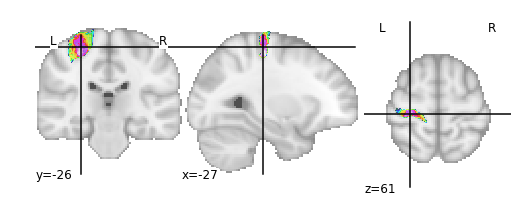

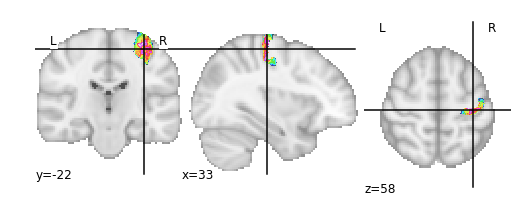

In [2]:
mask_lM1 = nib.load('masks/space-MNI152NLin2009cAsym_label-lM1_probseg.nii.gz')
mask_rM1 = nib.load('masks/space-MNI152NLin2009cAsym_label-rM1_probseg.nii.gz')
plotting.plot_roi(mask_lM1)
plotting.plot_roi(mask_rM1)

array([[   1.5,    0. ,    0. ,  -96.5],
       [   0. ,    1.5,    0. , -132.5],
       [   0. ,    0. ,    1.5,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

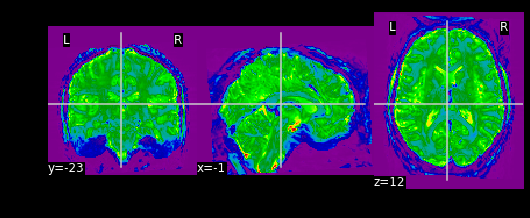

In [3]:
# to 1p5mm epi-space
epi = './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_boldref.nii.gz'
plotting.plot_epi(epi)
nib.load(epi).affine

In [4]:
mask_lM1_path = 'masks/space-MNI152NLin2009cAsym_label-lM1_probseg.nii.gz'
mask_rM1_path = 'masks/space-MNI152NLin2009cAsym_label-rM1_probseg.nii.gz'

In [5]:
res = nighres.registration.embedded_antsreg(source_image=mask_lM1_path, 
                                            target_image=epi, 
                                            run_rigid=False, run_affine=False, run_syn=False, 
                                            rigid_iterations=0,
                                            affine_iterations=0, 
                                            coarse_iterations=0, 
                                            fine_iterations=0, 
                                            medium_iterations=0, save_data=True)
rM1 = nighres.registration.apply_coordinate_mappings(image=mask_rM1_path, mapping1=res['mapping'])


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to masks/
skip computation (use existing results)

Apply coordinate mappings


10041
9786


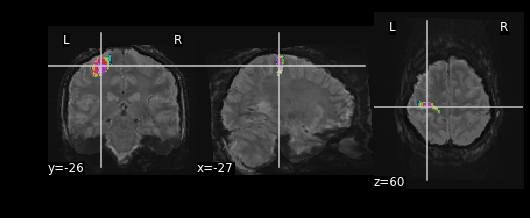

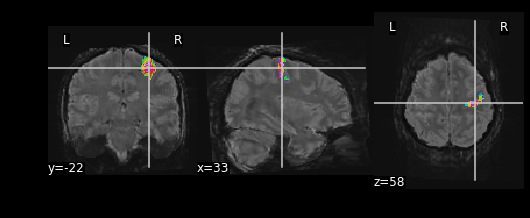

In [6]:
plotting.plot_roi(res['transformed_sources'][0], bg_img=epi)
plotting.plot_roi(rM1['result'], bg_img=epi)

print((res['transformed_sources'][0].get_data()>0).sum())
print((rM1['result'].get_data()>0).sum())

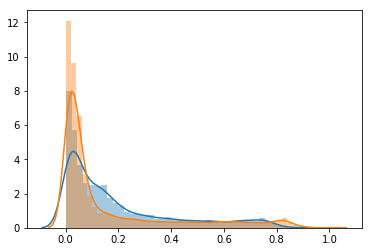

In [7]:
def make_distplot(nii):
    data = nii.get_data().ravel()
    data = data[data>0]
    sns.distplot(data)
    
make_distplot(rM1['result'])
make_distplot(res['transformed_sources'][0])

In [ ]:
rm1 = deepcopy(rM1['result'])  #nib.load(mask_rM1_path) #.get_data() #rM1['result']
lm1 = deepcopy(res['transformed_sources'][0]) #res['transformed_source']

def threshold_(nii, value):
    data = nii.get_data()
    data[data < value] = 0
    return nib.Nifti1Image(data, affine=nii.affine)

print(sum(threshold_(rm1, 0.751426).get_data()>0).sum())
print(sum(threshold_(lm1, 0.8266).get_data()>0).sum())

200
200


200
200


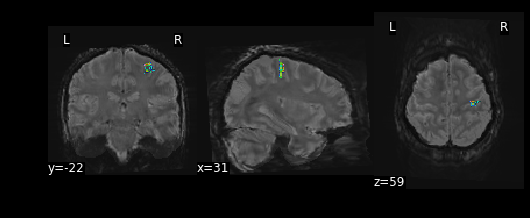

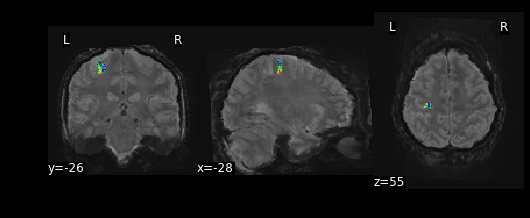

In [ ]:
## threshold, get 200 most-likely voxels
rm1 = deepcopy(rM1['result'])  #nib.load(mask_rM1_path) #.get_data() #rM1['result']
lm1 = deepcopy(res['transformed_sources'][0]) #res['transformed_source']

def threshold_(nii, value):
    data = nii.get_data()
    data[data < value] = 0
    return nib.Nifti1Image(data, affine=nii.affine)

rm1_thresholded = threshold_(rm1, 0.751426)
lm1_thresholded = threshold_(lm1, 0.8266)
print(sum(rm1_thresholded.get_data()>0).sum())
print(sum(lm1_thresholded.get_data()>0).sum())

plotting.plot_roi(rm1_thresholded, bg_img=epi, draw_cross=False)
plotting.plot_roi(lm1_thresholded, bg_img=epi, draw_cross=False)

nib.save(rm1_thresholded, filename='masks/space-MNI152NLin2009cAsym-1p5mm_label-rM1_probseg.nii.gz')
nib.save(lm1_thresholded, filename='masks/space-MNI152NLin2009cAsym-1p5mm_label-lM1_probseg.nii.gz')

### extract timeseries from epis

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:2788: 

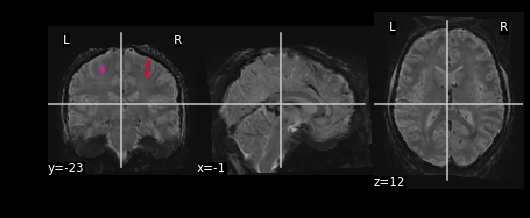

In [ ]:
from sklearn.utils import Bunch
M1_atlas = Bunch(labels=['rM1', 'lM1'], 
                 maps=nilearn.image.concat_imgs(['./masks/space-MNI152NLin2009cAsym-1p5mm_label-rM1_probseg.nii.gz',
                                                 './masks/space-MNI152NLin2009cAsym-1p5mm_label-lM1_probseg.nii.gz']))
plotting.plot_prob_atlas(M1_atlas.maps, bg_img=epi)

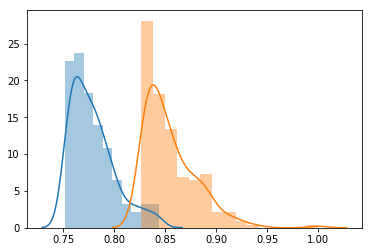

In [ ]:
make_distplot(image.index_img(M1_atlas.maps, 0))
make_distplot(image.index_img(M1_atlas.maps, 1))

In [ ]:
fns = glob.glob('./derivatives/ds-*/fmriprep/sub-*/func/sub-*_task-randomdotmotion_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
reg = re.compile('.*/ds-(?P<ds>[\d]+)/fmriprep/sub-(?P<sub>[\d]+)/func/.*_run-(?P<run>[\d]+)_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
sorted(fns)

<>:2: DeprecationWarning: invalid escape sequence \d


['./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 './derivatives/ds-01/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-02_space

In [ ]:
to_run = fns
def do_extract(fn, reg, M1_atlas):
    if reg.match(fn) is None:
        print('fn {} is None, skipping'.format(fn))
        return 0
    
    ds = reg.match(fn).groupdict()['ds']
    sub = reg.match(fn).groupdict()['sub']
    run = reg.match(fn).groupdict()['run']
    output_fn = '/home/stevenm/bias/extracted_signals/ds-{}/sub-{}_run-{}.csv'.format(ds, sub, run)
    brain_mask = '/home/stevenm/bias/derivatives/ds-{}/fmriprep/sub-{}/func/sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(str(ds).zfill(2), str(sub).zfill(2), str(sub).zfill(2), str(run).zfill(2))
    nii_fn = os.path.join('/home/stevenm/bias', fn)  # absolute path just to be sure
    if os.path.exists(output_fn):
        return 0
    
    print('Running {}'.format(reg.match(fn).groupdict()))
    print(output_fn)
    print(nii_fn)
    ts = roi.extract_timecourse_from_nii(M1_atlas,
                                         nii_fn,
                                         confounds=None,
                                         mask=brain_mask,
                                         t_r=3,
                                         high_pass=None)
    
    ts.to_csv(output_fn)
    return 0


In [ ]:
import multiprocessing as mp
from functools import partial

with mp.Pool(30) as p:
    p.map(partial(do_extract, M1_atlas=M1_atlas, reg=reg), to_run)

Running {'ds': '02', 'sub': '02', 'run': '03'}
/home/stevenm/bias/extracted_signals/ds-02/sub-02_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '02', 'run': '02'}
/home/stevenm/bias/extracted_signals/ds-02/sub-02_run-02.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '02', 'run': '01'}
/home/stevenm/bias/extracted_signals/ds-02/sub-02_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and se

In [ ]:
# for fn in fns:
#     do_extract(fn, reg=reg, M1_atlas=M1_atlas)

## Extract timeseries from functional masks

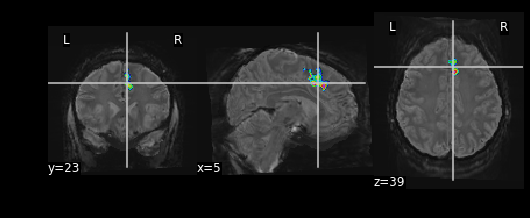

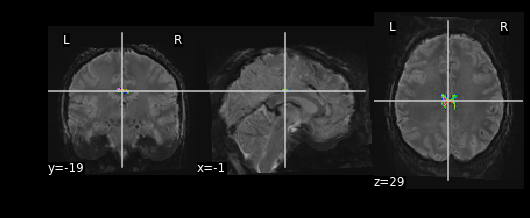

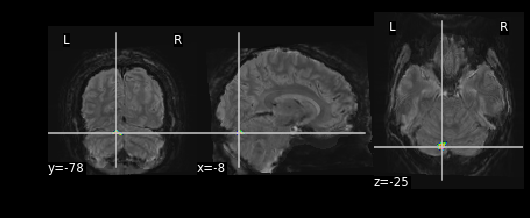

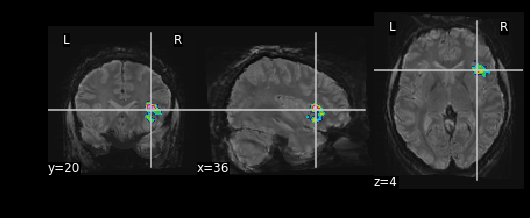

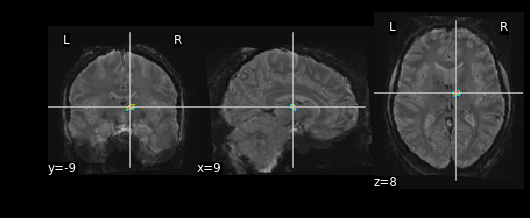

In [ ]:
from sklearn.utils import Bunch
func_atlas = Bunch(labels=['ACC', 'cc', 'cerebellar', 'insula', 'midbrain', 'parietal', 'rifg'], 
                 maps=nilearn.image.concat_imgs(['./masks_func/space-MNI152NLin2009cAsym_label-ACC.nii.gz',
                                                 './masks_func/space-MNI152NLin2009cAsym_label-cc.nii.gz',
                                                 './masks_func/space-MNI152NLin2009cAsym_label-cerebellar.nii.gz',
                                                 './masks_func/space-MNI152NLin2009cAsym_label-insula.nii.gz',
                                                 './masks_func/space-MNI152NLin2009cAsym_label-midbrain.nii.gz',
                                                 './masks_func/space-MNI152NLin2009cAsym_label-parietal.nii.gz',
                                                 './masks_func/space-MNI152NLin2009cAsym_label-rifg.nii.gz' ]))
plotting.plot_roi(image.index_img(func_atlas.maps, 0), bg_img=epi)
plotting.plot_roi(image.index_img(func_atlas.maps, 1), bg_img=epi)
plotting.plot_roi(image.index_img(func_atlas.maps, 2), bg_img=epi)
plotting.plot_roi(image.index_img(func_atlas.maps, 3), bg_img=epi)
plotting.plot_roi(image.index_img(func_atlas.maps, 4), bg_img=epi)

In [ ]:
to_run = fns
def do_extract(fn, reg, atlas):
    if reg.match(fn) is None:
        print('fn {} is None, skipping'.format(fn))
        return 0
    
    ds = reg.match(fn).groupdict()['ds']
    sub = reg.match(fn).groupdict()['sub']
    run = reg.match(fn).groupdict()['run']
    output_fn = '/home/stevenm/bias/extracted_signals_func/ds-{}/sub-{}_run-{}.csv'.format(ds, sub, run)
    
    #brain_mask = '/home/stevenm/bias/derivatives/ds-{}/fmriprep/sub-{}/func/sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(str(ds).zfill(2), str(sub).zfill(2), str(sub).zfill(2), str(run).zfill(2))
    brain_mask = '/home/stevenm/bias/derivatives/ds-{}/fmriprep/sub-{}/func/sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(str(ds).zfill(2), str(sub).zfill(2), str(sub).zfill(2), str(run).zfill(2))
    nii_fn = os.path.join('/home/stevenm/bias', fn)  # absolute path just to be sure
    if os.path.exists(output_fn):
        return 0
    
    print('Running {}'.format(reg.match(fn).groupdict()))
    print(output_fn)
    print(nii_fn)
    ts = roi.extract_timecourse_from_nii(atlas,
                                         nii_fn,
                                         confounds=None,
                                         mask=brain_mask,
                                         t_r=3,
                                         high_pass=None)
    
    ts.to_csv(output_fn)
    return 0


In [ ]:
import multiprocessing as mp
from functools import partial

with mp.Pool(30) as p:
    p.map(partial(do_extract, atlas=func_atlas, reg=reg), to_run)

Running {'ds': '02', 'sub': '02', 'run': '03'}
/home/stevenm/bias/extracted_signals_func/ds-02/sub-02_run-03.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '02', 'run': '02'}
/home/stevenm/bias/extracted_signals_func/ds-02/sub-02_run-02.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Running {'ds': '02', 'sub': '02', 'run': '01'}
/home/stevenm/bias/extracted_signals_func/ds-02/sub-02_run-01.csv
/home/stevenm/bias/./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
